In [114]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import plotly.graph_objects as go
import plotly.express as px

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from keras.layers import Flatten,Activation,Dense,Dropout,Conv2D,MaxPool2D
from sklearn.model_selection import train_test_split

from keras.losses import *
import keras

from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from PIL import ImageFile, Image
import seaborn as sns

In [ ]:
sns.set_style('darkgrid')
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [33]:
train_directory = '/kaggle/input/brain-tumor-classification-mri/Training'
test_directory = '/kaggle/input/brain-tumor-classification-mri/Testing'

In [34]:
os.listdir(train_directory)

['no_tumor', 'pituitary_tumor', 'meningioma_tumor', 'glioma_tumor']

In [35]:
def in_color(txt_msg,fore_tupple=(0,255,0),back_tupple=(50,50,100), same_line=False):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    # default parameter print in cyan foreground and gray background
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    if same_line:        
        print(msg .format(mat), end='', flush=True)# does not go to a new line so next print is on the same line
    else:        
        print(msg .format(mat), flush=True)
    print('\33[0m', end='',flush=True) # returns default print color to back to black
    return

In [36]:
def make_dataframes(train_dir, test_dir=None, val_dir=None, limiter=None):
    
    bad_images = []
    # check what directories exist
    if test_dir == None and val_dir==None:
        dirlist = [train_dir]
        names = ['train']
    elif test_dir == None:
        dirlist = [train_dir,  val_dir]
        names = ['train', 'valid']
    elif val_dir == None:
        dirlist = [train_dir,  test_dir]
        names = ['train', 'test'] 
    else:
        dirlist = [train_dir, test_dir, val_dir]
        names = ['train','test', 'valid']
    ht = 0 # set initial value of height counter
    wt = 0  # set initial value of width counter
    total_good_files = 0 # set initial value of total number of good image files counter
    zipdir = zip(names, dirlist)
    for name, d in zipdir: #iterate through the  names and directories
        filepaths = [] # initialize list of filepaths
        labels = [] # initialize list of class labels
        classlist = sorted(os.listdir(d) )   # get a list of all the classes in alphanumeric order   
        for klass in classlist: # iterate through the list of classes
            msg=f'processing images in {name} directory for class {klass}                                                  '
            print(msg, '\r', end='')
            good_file_count = 0 # initialize the good_file count for this class
            classpath = os.path.join(d, klass) # define the full path to the class            
            if os.path.isdir(classpath): # ensure we are working with a directory and not a spurious file
                flist = sorted(os.listdir(classpath)) # make a list of all the files for this class
                if limiter != None: # check if a limiter value was specified that determmine how many files to use in any class
                    if limiter < len(flist): # if there are more files than the value of limiter than randomly sample a limiter number of files
                        flist = np.random.choice(flist, limiter, replace=False)                        
                for f in flist:
                    fpath = os.path.join(classpath,f) # create the full path to the image file
                    index = f.rfind('.')
                    ext = f[index+1:].lower() # the the file's extension
                    if ext not in ['jpg', 'jpeg', 'tiff', 'png', 'bmp'] :   # make sure the file extension is one that works with Keras                     
                        bad_images.append(fpath) # if not a proper extension store the filepath in the bad images list
                    else:                    
                        try: # check if image files are defective if so do not include in dataframe
                            img = cv2.imread(fpath)
                            h = img.shape[0]
                            w = img.shape[1]
                            ht += h # add images height and width to the counters
                            wt += w  
                            good_file_count += 1   
                            total_good_files += 1
                            filepaths.append(fpath) # append the filepath to the list of valid filepaths
                            labels.append(klass) # append the file's class label to the labels list

                        except:
                            bad_images.append(fpath) # if the image file is defective add the filepath to the list of bad images
        print('')
        Fseries = pd.Series(filepaths, name='filepaths') # make a pandas series for the filenames and labels lists
        Lseries = pd.Series(labels, name='labels')
        df = pd.concat([Fseries, Lseries], axis=1) # make a dataframe with columns filepaths and labels
        # depending on which directory we are iterating through create dataframes
        if name =='valid':
            valid_df = df
        elif name == 'test':
            test_df = df
        else:
            if test_dir == None and val_dir == None: # create train_df, test_df and valid_df from df
                pdf = df
                train_df, dummy_df = train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
                valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])
            elif test_dir == None: # create just a train_df and test_df 
                pdf = df
                train_df, test_df = train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            elif val_dir == None:  # create a train_df and a valid_df                          
                pdf = df                
                train_df, valid_df = train_test_split(pdf, train_size=.8, shuffle=True, random_state=123, stratify=pdf['labels'])
            else:
                train_df = df # test and valid dataframes exists so train_df is just df
    classes = sorted(train_df['labels'].unique())
    class_count = len(classes)    
    # calculate the average image height and with 
    have = int(ht/total_good_files)
    wave = int(wt/total_good_files)
    aspect_ratio = have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts = list(train_df['labels'].value_counts())    
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df)) 
    if len(bad_images) == 0:
        in_color('All image files were properly processed and used in the dataframes')
    else:
        in_color(f'the are {len(bad_images)} bad image files and {total_good_files} proper image files in the dataset')
        for f in bad_images:
            print (f)    
    return train_df, valid_df#, classes, class_count, max(counts), min(counts), have, wave

In [37]:
df, test = make_dataframes(train_directory, test_directory)

processing images in train directory for class pituitary_tumor                                                    
processing images in test directory for class pituitary_tumor                                                    
number of classes in processed dataset=  4
the maximum files in any class in train_df is  661   the minimum files in any class in train_df is  316
train_df length:  2295   test_df length:  394   valid_df length:  574
the are 1 bad image files and 3263 proper image files in the dataset
/kaggle/input/brain-tumor-classification-mri/Training/pituitary_tumor/p (392).jpg


In [38]:
df.head()

,filepaths,labels
1995,/kaggle/input/brain-tumor-classification-mri/T...,no_tumor
404,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2169,/kaggle/input/brain-tumor-classification-mri/T...,pituitary_tumor
317,/kaggle/input/brain-tumor-classification-mri/T...,glioma_tumor
2444,/kaggle/input/brain-tumor-classification-mri/T...,pituitary_tumor


In [ ]:
df.shape

In [39]:
img_size = (224,224)
image_shape = img_size+(3,)
N_CLASSES = 4
BATCH_SIZE = 64

In [40]:
# loading training data and rescaling it using ImageDataGenerator
gen = ImageDataGenerator(dtype='float32', rescale= 1./255., validation_split=.35)
train_generator = gen.flow_from_dataframe(df, 
                                    x_col='filepaths', 
                                    y_col="labels", 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=True, 
                                    subset="training",
                                    batch_size=BATCH_SIZE)

Found 1492 validated image filenames belonging to 4 classes.


In [41]:
valid_gen = gen.flow_from_dataframe(df, 
                                    x_col='filepaths', 
                                    y_col="labels", 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=False, 
                                    subset="validation",
                                    batch_size=BATCH_SIZE)

Found 803 validated image filenames belonging to 4 classes.


In [42]:
test_gen = gen.flow_from_dataframe(test, 
                                    x_col='filepaths', 
                                    y_col="labels", 
                                    target_size=img_size,
                                    class_mode='categorical', 
                                    color_mode='rgb', 
                                    shuffle=False, 
                                    batch_size=BATCH_SIZE)

Found 574 validated image filenames belonging to 4 classes.


## EDA

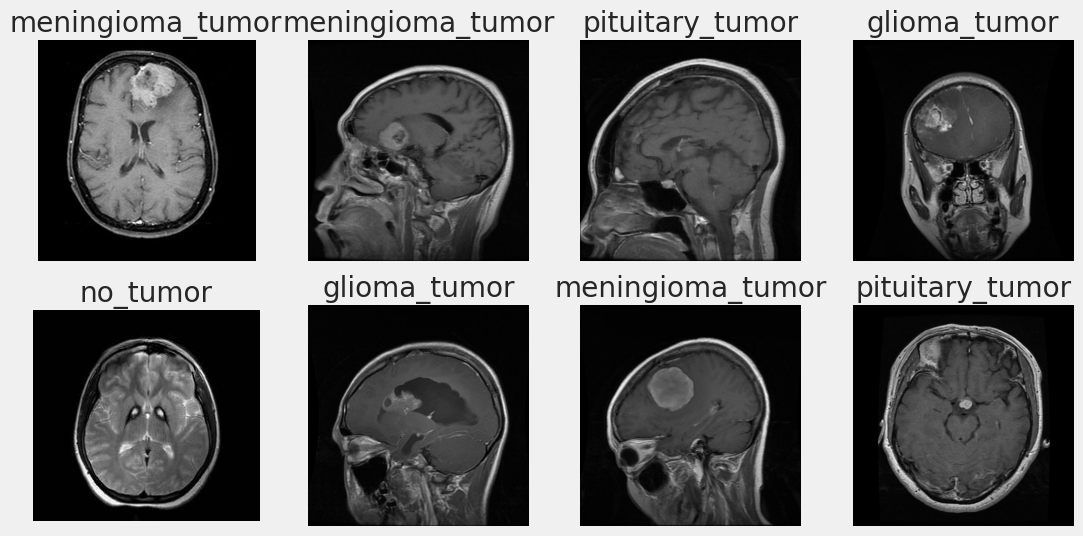

In [108]:
x = 0
plt.figure(figsize=(12, 6))
for i in df.sample(8).iterrows():
    #plt.imshow(i[1][0].numpy().astype("uint8"))
    ax = plt.subplot(2, 4, x + 1)
    plt.imshow(Image.open(i[1][0]))
    plt.title(i[1][1])
    plt.axis("off")
    x += 1

In [44]:
df["labels"].value_counts()

glioma_tumor        661
pituitary_tumor     661
meningioma_tumor    657
no_tumor            316
Name: labels, dtype: int64

In [45]:
class_count = df["labels"].value_counts().tolist()

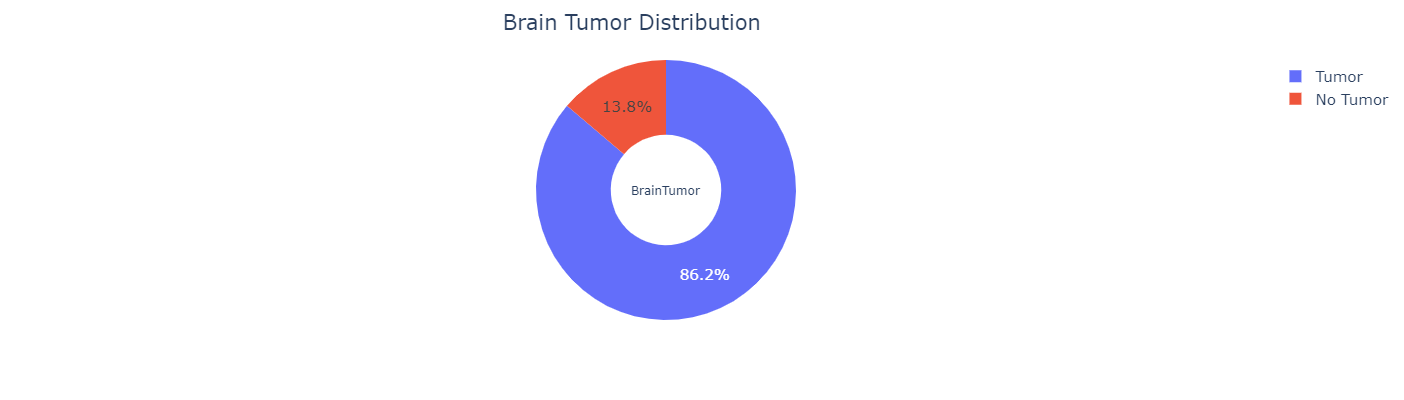

In [115]:
fig = px.pie(values=[np.sum(class_count[:3]),
                     class_count[-1]], names=['Tumor','No Tumor'],hole=0.425, height=400,width=400 )
fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45,annotations=[dict(text='BrainTumor',font_size=12, showarrow=False,height=400,width=350)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

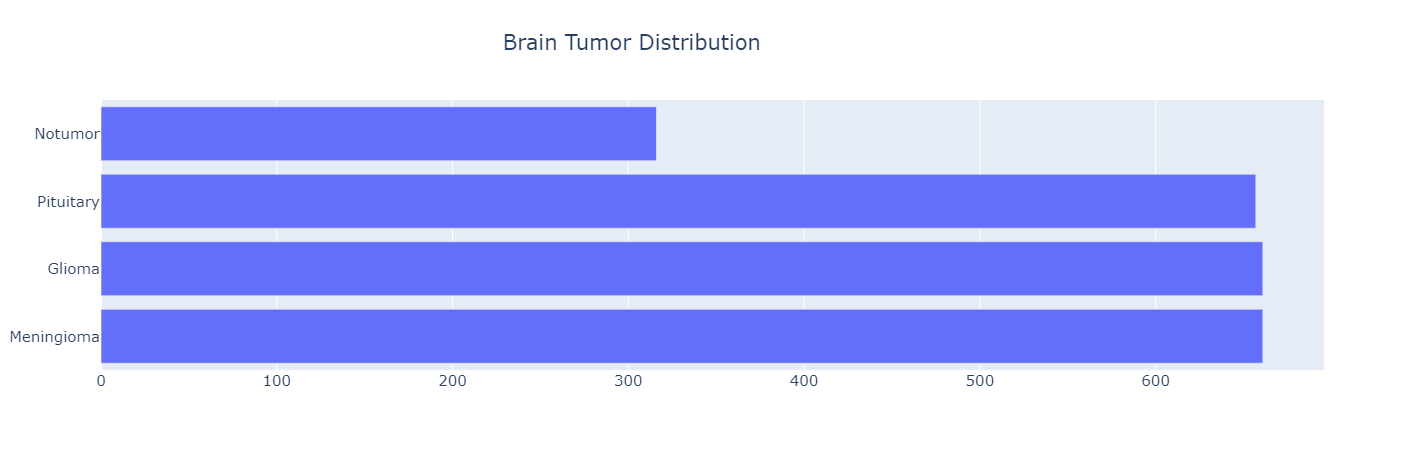

In [116]:
fig = go.Figure(go.Bar(
            x=class_count,
            y=['Meningioma','Glioma','Pituitary','Notumor'],
            orientation='h', ))

fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45)
fig.show()

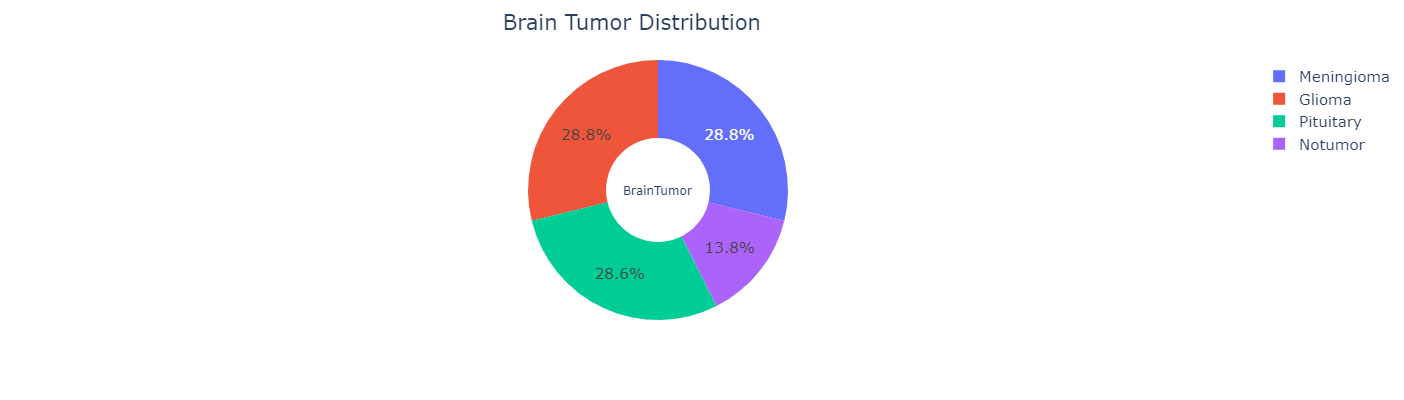

In [117]:
fig=px.pie(values = class_count, names=['Meningioma','Glioma','Pituitary','Notumor'],hole=0.4, height=400,width=400)
fig.update_layout(title='Brain Tumor Distribution',font_size=15,title_x=0.45,annotations=[dict(text='BrainTumor',font_size=12, showarrow=False,height=800,width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

In [66]:
base_model = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet', pooling='avg', input_shape=image_shape,)

In [50]:
#base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [51]:
def make_model(base_model, num_class=4):
    image_batch, label_batch = next(iter(train_generator))
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)
    
    prediction_layer = tf.keras.layers.Dense(num_class, activation='softmax')
    prediction_batch = prediction_layer(feature_batch)
    print(prediction_batch.shape)
    base_model.trainable = True
    # Fine-tune from this layer onwards
    fine_tune_at = 150

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]: layer.trainable =  False
    
    inputs = tf.keras.Input(shape=(image_shape))
    x = base_model(inputs, training=False)
    x = tf.keras.layers.Dropout(0.5)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)
    #Model compilations
    base_learning_rate = 0.0001
    model.compile(loss="categorical_crossentropy",#tf.keras.losses.BinaryCrossentropy(), #from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              metrics=['accuracy'])
    
    return model

In [70]:
def tr_plot(tr_data):
    start_epoch = 0
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']   
    Epoch_count = len(tacc)+ start_epoch
    Epochs = []
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss = np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch) 
    #f1_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')    
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return 

### ResNet50

In [68]:
model = make_model(base_model)

(64, 2048)
(64, 4)


In [59]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [109]:
def evaluate(model, gen):    
    y_pred = []
    error_list = []
    error_pred_list = []
    y_true = gen.labels
    classes = list(gen.class_indices.keys())
    class_count = len(classes)
    errors = 0
    preds = model.predict(gen, verbose=1)
    tests = len(preds)    
    for i, p in enumerate(preds):        
        pred_index = np.argmax(p)         
        true_index = gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors = errors + 1
            file = gen.filenames[i]
            error_list.append(file)
            error_class = classes[pred_index]
            error_pred_list.append(error_class)
        y_pred.append(pred_index)
    
    acc = accuracy_score(y_true, y_pred)
    msg = f'There were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    in_color(msg, (0, 350, 350), (100,100,100)) # cyan foreground
    ypred = np.array(y_pred)
    ytrue = np.array(y_true)
    f1score = f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <= 30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    return errors, tests, error_list, error_pred_list, f1score

In [60]:
ImageFile.LOAD_TRUNCATED_IMAGES = True
def train(model):
#Model training
    callbacks = [
     tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True,),
     #tf.keras.callbacks.TensorBoard(log_dir='./logs/Resnetlog' , histogram_freq=1),    
    ]
    history = model.fit(x=train_generator, 
                        validation_data=valid_gen,
                        epochs=100, 
                        verbose=1, 
                        shuffle=True,
                        callbacks=callbacks)
    return history

In [69]:
hist = train(model)

Epoch 1/100
24/24 [==============================] - 22s 631ms/step - loss: 1.4609 - accuracy: 0.3016 - val_loss: 1.2997 - val_accuracy: 0.4595
Epoch 2/100
24/24 [==============================] - 13s 544ms/step - loss: 1.3142 - accuracy: 0.3660 - val_loss: 1.2132 - val_accuracy: 0.4433
Epoch 3/100
24/24 [==============================] - 13s 563ms/step - loss: 1.2374 - accuracy: 0.4256 - val_loss: 1.1384 - val_accuracy: 0.5268
Epoch 4/100
24/24 [==============================] - 13s 556ms/step - loss: 1.1572 - accuracy: 0.4765 - val_loss: 1.0569 - val_accuracy: 0.5704
Epoch 5/100
24/24 [==============================] - 13s 557ms/step - loss: 1.0627 - accuracy: 0.5369 - val_loss: 1.0586 - val_accuracy: 0.5081
Epoch 6/100
24/24 [==============================] - 13s 553ms/step - loss: 1.0247 - accuracy: 0.5402 - val_loss: 0.9848 - val_accuracy: 0.5965
Epoch 7/100
24/24 [==============================] - 13s 538ms/step - loss: 0.9621 - accuracy: 0.5972 - val_loss: 0.9532 - val_accuracy:

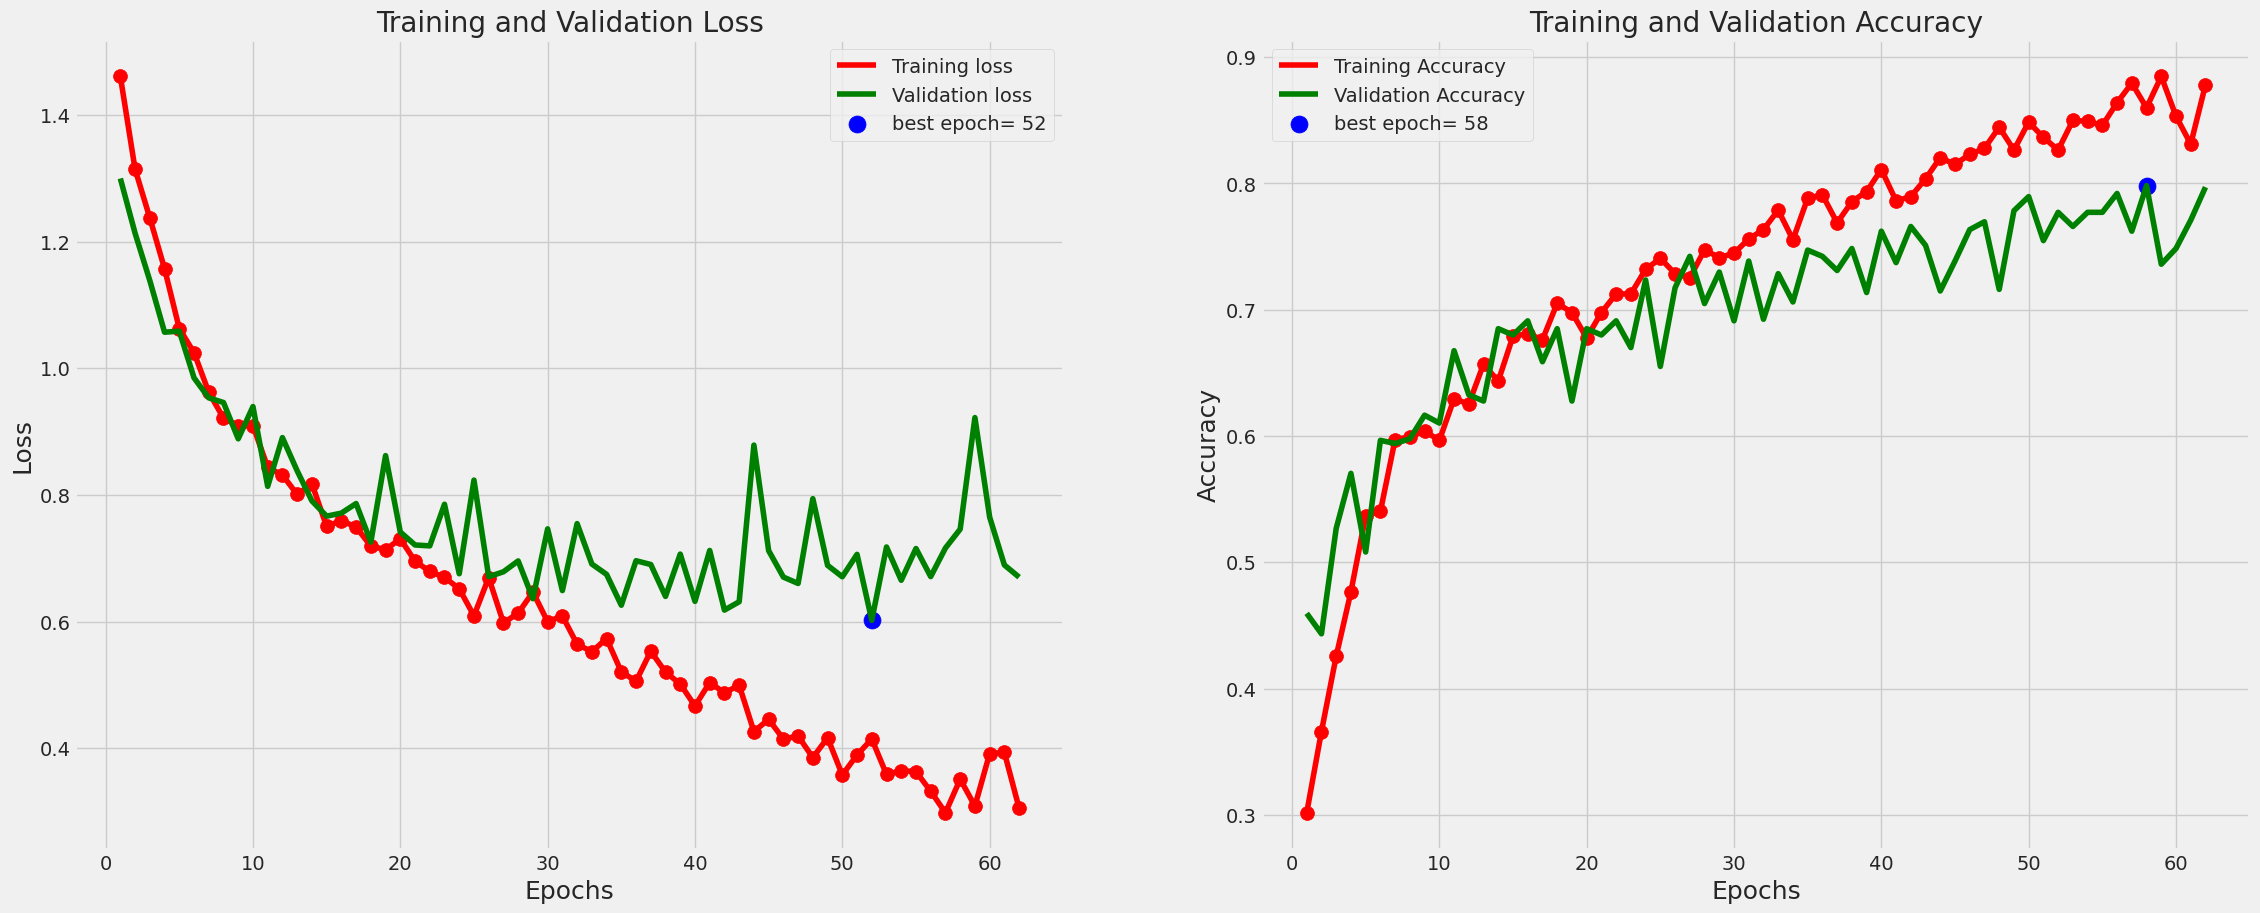

In [71]:
tr_plot(hist)

In [88]:
# _ = evaluate(model, train_generator)

13/13 [==============================] - 5s 383ms/step
There were 179 errors in 803 tests for an accuracy of   0.78


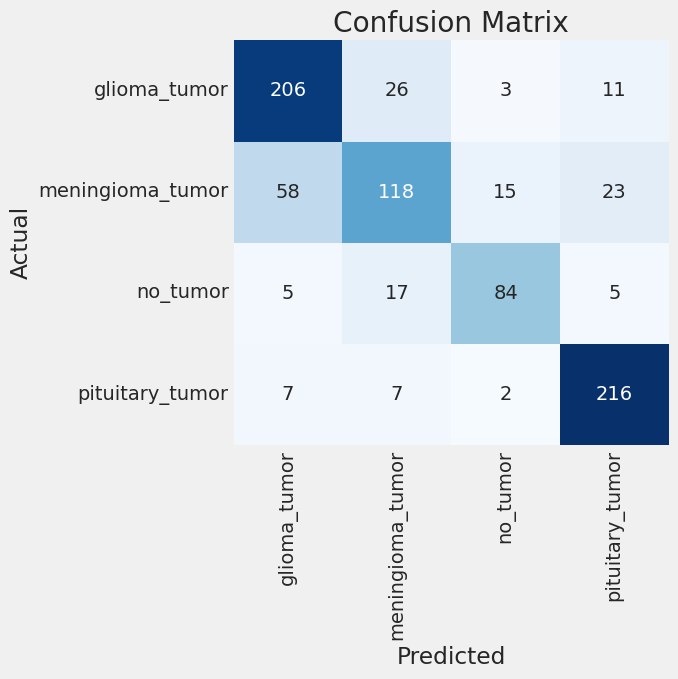

In [110]:
_ = evaluate(model, valid_gen)

9/9 [==============================] - 4s 425ms/step
There were 136 errors in 574 tests for an accuracy of   0.76


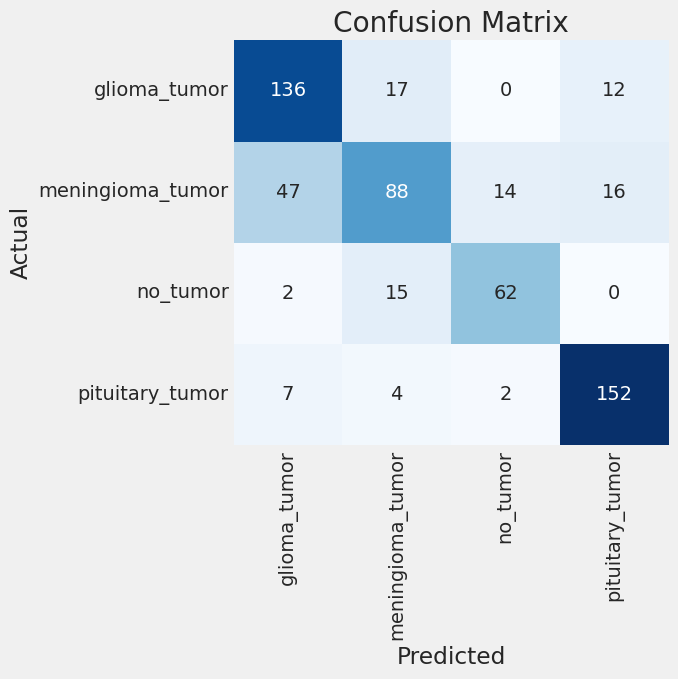

In [111]:
_ = evaluate(model, test_gen)

### MobileNetV3Small

In [75]:
base_model1 = tf.keras.applications.MobileNetV3Small(include_top=False, weights="imagenet",input_shape=image_shape, pooling='max')

4334752/4334752 [==============================] - 0s 0us/step


In [76]:
clf = make_model(base_model1)

(64, 576)
(64, 4)


In [77]:
hist1 = train(clf)

Epoch 1/100
24/24 [==============================] - 24s 566ms/step - loss: 1.4839 - accuracy: 0.2748 - val_loss: 1.3592 - val_accuracy: 0.2665
Epoch 2/100
24/24 [==============================] - 12s 496ms/step - loss: 1.3594 - accuracy: 0.2815 - val_loss: 1.3565 - val_accuracy: 0.3076
Epoch 3/100
24/24 [==============================] - 12s 520ms/step - loss: 1.3660 - accuracy: 0.2909 - val_loss: 1.3429 - val_accuracy: 0.2665
Epoch 4/100
24/24 [==============================] - 12s 503ms/step - loss: 1.3498 - accuracy: 0.2902 - val_loss: 1.3480 - val_accuracy: 0.2889
Epoch 5/100
24/24 [==============================] - 12s 522ms/step - loss: 1.3512 - accuracy: 0.3029 - val_loss: 1.3363 - val_accuracy: 0.2677
Epoch 6/100
24/24 [==============================] - 12s 495ms/step - loss: 1.3415 - accuracy: 0.2869 - val_loss: 1.3134 - val_accuracy: 0.2628
Epoch 7/100
24/24 [==============================] - 12s 492ms/step - loss: 1.3400 - accuracy: 0.2942 - val_loss: 1.3440 - val_accuracy:

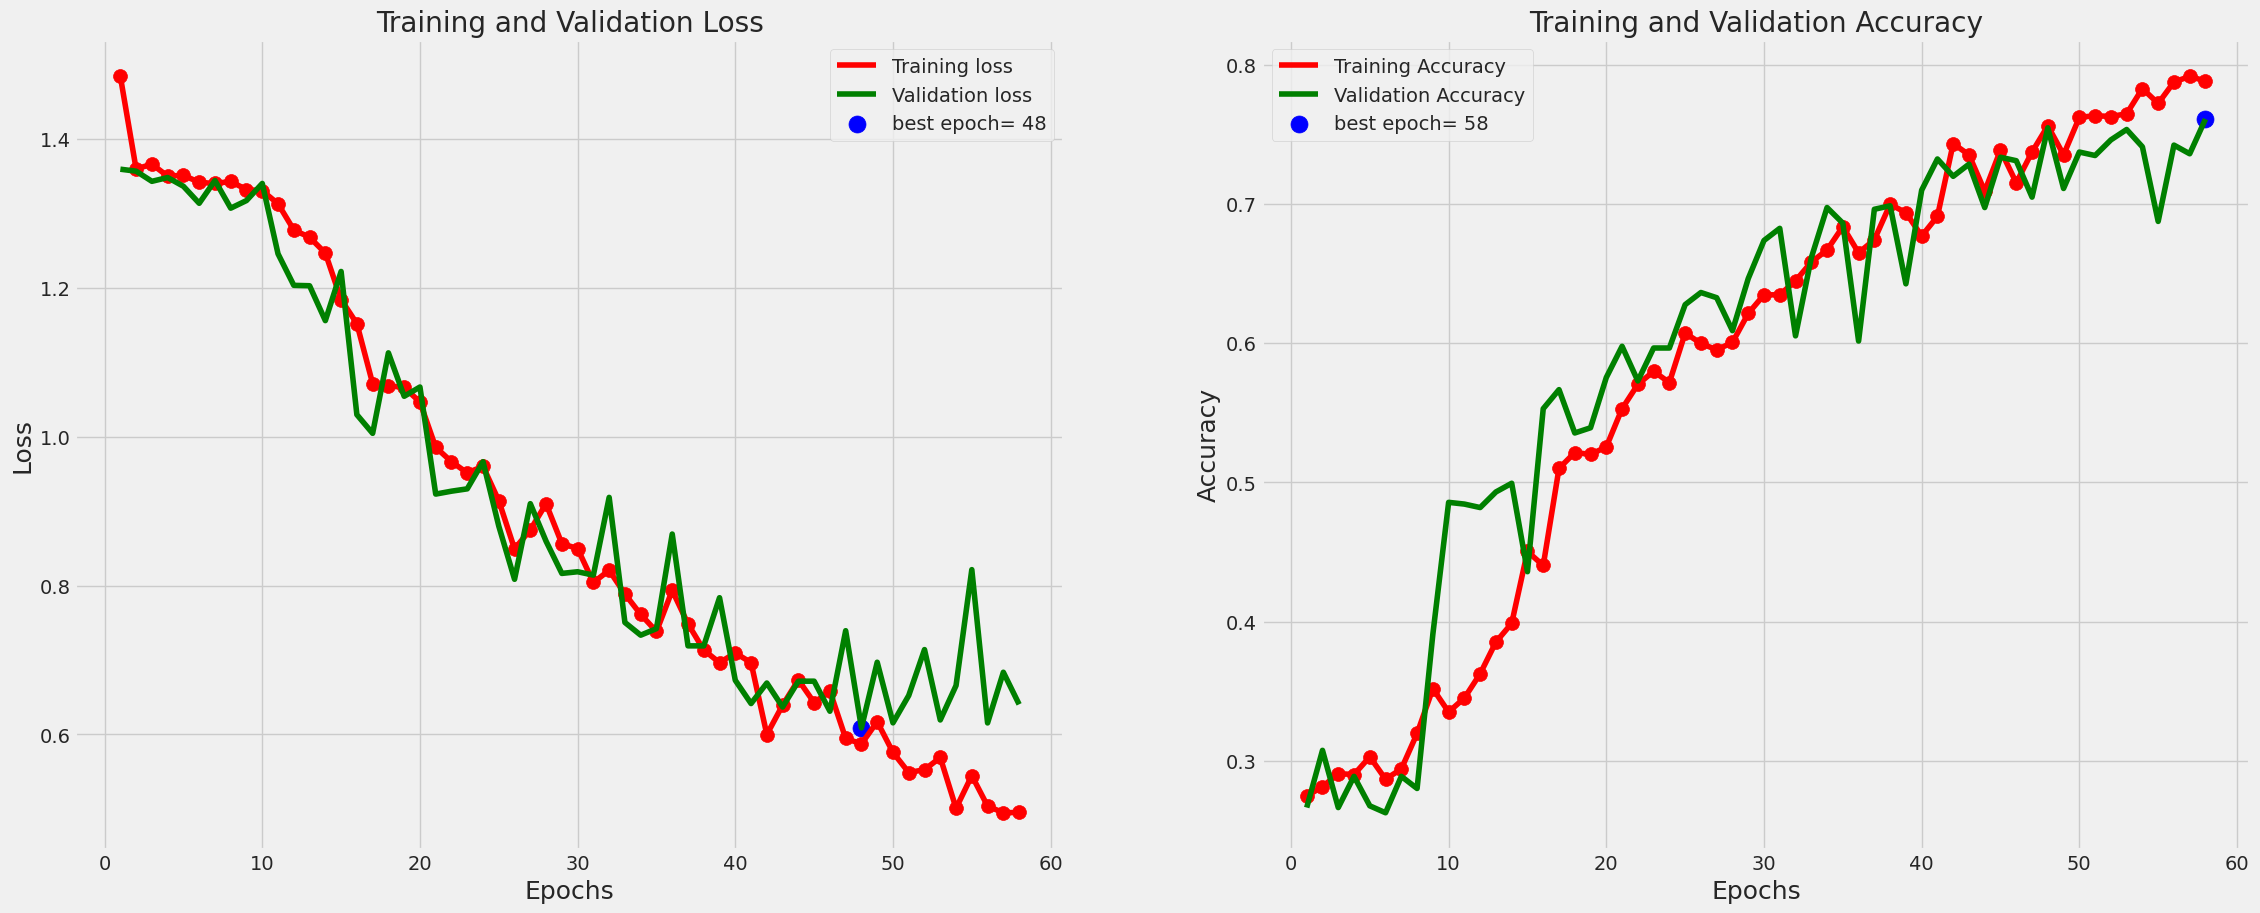

In [78]:
tr_plot(hist1)

13/13 [==============================] - 4s 308ms/step
There were 197 errors in 803 tests for an accuracy of   0.75


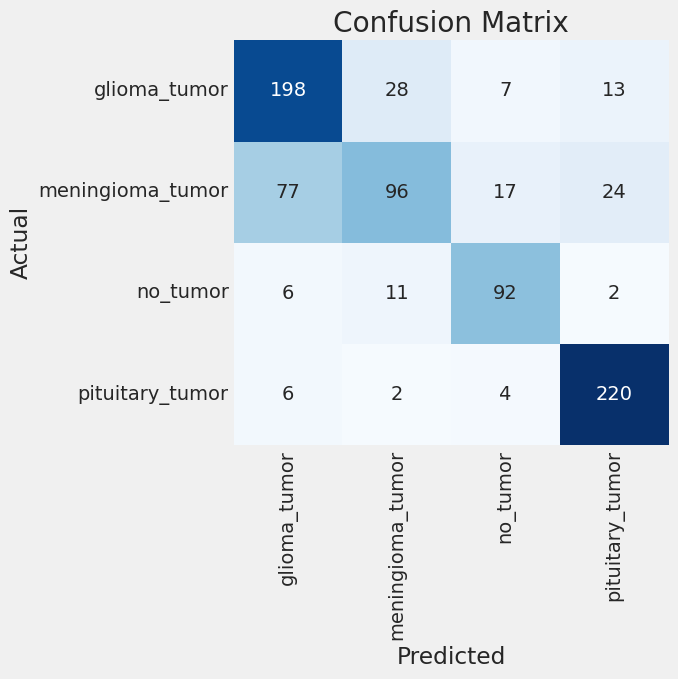

In [112]:
_ = evaluate(clf, valid_gen)

9/9 [==============================] - 3s 340ms/step
There were 160 errors in 574 tests for an accuracy of   0.72


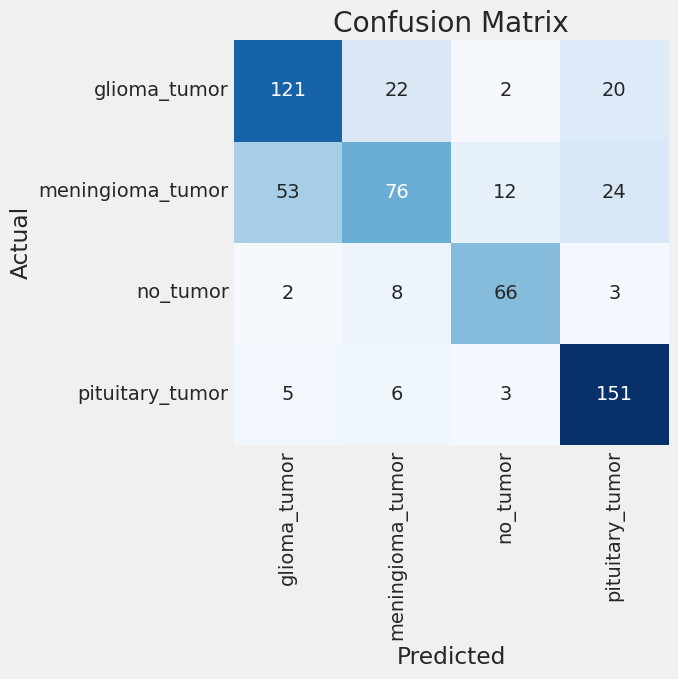

In [113]:
_ = evaluate(clf, test_gen)